In [1]:
import numpy as np
import pandas as pd
import yahoo_fin.stock_info as si
import get_all_tickers.get_tickers as gt
import yfinance as yf
import json
import datetime

In [2]:
price_data = pd.read_csv("../stock_price_data_from_2016.csv", index_col=0)
fundamental_data = pd.read_csv("../relevant_fundamentals.csv", index_col=0)
funds = pd.read_csv("../fundamentals.csv", index_col=0)
price_data["date"] = price_data.index
test_df = price_data[price_data.ticker == "MSFT"]


### write functions

In [153]:
def get_funds_date(date, ticker):
    # first check if there is a date before the starting date of the analysis
    ticker_funds = funds[funds.ticker == ticker]
    ticker_funds = ticker_funds.sort_values(by = "date", ascending = False)
    for date in ticker_funds.date:
        if date < start_date:
            
            day = int(date[-2:])
            month = int(date[-5:-3])
            year = int(date[:4])
            date = datetime.date(year,month,day)
            date = date.strftime("%Y-%m-%d")
            return date
    return np.nan
            
        

def get_correct_date(date, test_df):
    day = int(date[:2])
    month = int(date[3:5])
    year = int(date[-4:])
    date = datetime.date(year,month,day)
    date = date.strftime("%Y-%m-%d")
    while len(test_df[test_df.date == date]) == 0:
        if month == 12 and day == 31:
            year += 1
            day = 1
            month = 1
            date = datetime.date(year,month,day)
            date = date.strftime("%Y-%m-%d")

        else:
            try:
                day += 1
                date = datetime.date(year,month,day)
                date = date.strftime("%Y-%m-%d")

            except:
                month += 1
                day = 1
                date = datetime.date(year,month,day)
                date = date.strftime("%Y-%m-%d")
    return date

### Set date of the analysis

In [154]:
start_date = "01.02.2019" # this is how a user would input the date
end_date = "01.02.2020"
start_date = get_correct_date(start_date, test_df)
end_date = get_correct_date(end_date, test_df)
start_date_data = price_data[price_data.date == start_date]


#### This function computes the variables date for all tickers

In [155]:
funds_dates = []
funds_ticker = []
funds_at = []
funds_op = []
funds_so = []
prices = []
for ticker in funds.ticker.unique():
    
    rel_date = get_funds_date(start_date, ticker)
    try:
        funds_at.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["at"].item())
    except:
        funds_at.append(np.nan)
    try:
        funds_op.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["op"].item())
    except:
        funds_op.append(np.nan)
    try:
        funds_so.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["so"].item())
    except:
        funds_so.append(np.nan)
    try:
        prices.append(start_date_data[start_date_data.ticker == ticker]["adjclose"].item())
    except:
        prices.append(np.nan)
    
    funds_dates.append(rel_date)
    funds_ticker.append(ticker)
    
fund_df = pd.DataFrame({
    "ticker" : funds_ticker,
    "date" : funds_dates,
    "at" : funds_at,
    "op" : funds_op,
    "so" : funds_so,
    "adjclose" : prices
})

fund_df


,ticker,date,at,op,so,adjclose
0,DCT,2018-11-30,NaN,-7615000.0,NaN,NaN
1,GVA,2018-12-31,2.476601e+09,28610000.0,467000.0,40.845387
2,UK,2018-12-31,4.974686e+09,-137510000.0,NaN,NaN
3,YGMZ,2018-12-31,1.588355e+07,1172125.0,9250.0,NaN
4,AGMH,NaN,NaN,NaN,NaN,26.020000
...,...,...,...,...,...,...
4775,SBG,NaN,NaN,NaN,NaN,NaN
4776,SNPR,NaN,NaN,NaN,NaN,NaN
4777,TWCT,NaN,NaN,NaN,NaN,NaN
4778,VACQ,NaN,NaN,NaN,NaN,NaN


### Add new variables

In [156]:
# market value
fund_df["mar_cap"] = fund_df.so * fund_df.adjclose

In [157]:
# book-to-market
fund_df["beme"] = fund_df["at"]/fund_df["mar_cap"]

In [158]:
# op to at
fund_df["prof"] = fund_df["op"]/fund_df["at"]

### Now compute the momentum

In [159]:
# two dataframes
start_price = price_data[price_data.date == start_date]
end_price = price_data[price_data.date == end_date]

In [160]:
momentum_list = []
mom_ticker_list = []
for ticker in start_price.ticker:
    try:
        date_price = start_price[start_price.ticker == ticker][:1]["adjclose"].item()
        today_price = end_price[end_price.ticker == ticker][:1]["adjclose"].item()
        momentum = today_price - date_price
        momentum_list.append(momentum)
        mom_ticker_list.append(ticker)
    except:
        pass
    
m_df = pd.DataFrame({
    "ticker" : mom_ticker_list,
    "momentum" : momentum_list
})

m_df = m_df.sort_values(by = "momentum", ascending = False)
m_df.reset_index(drop = True, inplace = True)

In [161]:

momentum_stocks = df[:30]["ticker"].to_list()

In [162]:
value_stocks_df = fund_df.sort_values(by = "beme", ascending = False)
profit_stocks_df = fund_df.sort_values(by = "prof", ascending = False)

In [163]:
value_stocks = value_stocks_df[:15]["ticker"].to_list()

In [164]:
profit_stocks = profit_stocks_df[:15]["ticker"].to_list()

In [165]:
print(momentum_stocks, value_stocks, profit_stocks)

['PTRS', 'NVR', 'CABO', 'AMZN', 'GOOG', 'GOOGL', 'CMG', 'MELI', 'TDG', 'SHOP', 'CSGP', 'WTM', 'EQIX', 'AZO', 'CHTR', 'FICO', 'PAYC', 'CHE', 'Y', 'RETA', 'SHW', 'TDY', 'MKTX', 'LMT', 'LRCX', 'TYL', 'GLPG', 'TTD', 'BLK', 'NOW', 'MSCI', 'FCNCA', 'MKL', 'FLT', 'MTD', 'ANSS', 'BIO', 'PODD', 'ASML', 'MA'] ['GVA', 'DCT', 'UK', 'YGMZ', 'AGMH', 'ALGS', 'ANTE', 'BLCT', 'BROG', 'BRQS', 'CCRC', 'CLEU', 'CLWT', 'CVAC', 'DNK'] ['YGMZ', 'GVA', 'UK', 'DCT', 'AGMH', 'ALGS', 'ANTE', 'BLCT', 'BROG', 'BRQS', 'CCRC', 'CLEU', 'CLWT', 'CVAC', 'DNK']


In [166]:
import pandas as pd
import random
import yahoo_fin.stock_info as si
import yfinance as yf
import json
import csv
import re
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import get_all_tickers.get_tickers as gt
from lxml import html
import matplotlib.pyplot as plt
import json

## Scrape Sector and Country to diversify

Create Dataframes

In [167]:
# get a list of all countries

with open("../countries.json", "r") as f:
    countries = json.load(f)

1. Value Stocks

In [168]:
name_list = []

for ticker in value_stocks:
    try:
        url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url_shares_outstanding.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in value_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in value_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

value_df = pd.DataFrame({
    "ticker" : value_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

2. Momentum Stocks

In [169]:
name_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        info[0].text
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

momentum_df = pd.DataFrame({
    "ticker" : momentum_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

3. Profit Stocks

In [170]:
name_list = []

for ticker in profit_stocks:
    try:
        url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url_shares_outstanding.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in profit_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        info[0].text
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in profit_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

profit_df = pd.DataFrame({
    "ticker" : profit_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

# Now lets form a diversified Portfolio

### It should consist of 10-15 stocks, diversified over industry and country

In [171]:
portfolio_df = pd.DataFrame(columns=["ticker", "names", "industry", "country"])
index = 0
mom = 0
val = 0
pro = 0
origin_list = [] # list for the origins of the stocks
c_list = []
i_list = []

while (len(portfolio_df) < 15) & (index < 40):
    
    try:
        if mom <= 5 and momentum_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(momentum_df.loc[index]["country"]) < 4 and i_list.count(momentum_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(momentum_df.loc[index])
            c_list.append(momentum_df.loc[index]["country"])
            i_list.append(momentum_df.loc[index]["industry"])
            mom += 1
            origin_list.append("mom")
            index += 1
            
            
        elif val <= 3 and value_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(value_df.loc[index]["country"]) < 4 and i_list.count(value_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(value_df.loc[index])

            c_list.append(value_df.loc[index]["country"])
            i_list.append(value_df.loc[index]["industry"])
            val += 1
            origin_list.append("val")
        
            
        elif pro <= 3 and profit_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(profit_df.loc[index]["country"]) < 4 and i_list.count(profit_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(profit_df.loc[index])

            c_list.append(profit_df.loc[index]["country"])
            i_list.append(profit_df.loc[index]["industry"])
            pro += 1
            origin_list.append("pro")
        else:
            index += 1
        
        
    except:
        index += 1
    
portfolio_df["origin"] = origin_list
    

In [172]:
portfolio_df.reset_index(drop = True, inplace = True)
portfolio_df

,ticker,names,industry,country,origin
0,PTRS,Partners Bancorp,Financial Services,United States,mom
1,NVR,"NVR, Inc.",Consumer Cyclical,United States,mom
2,CABO,"Cable One, Inc.",Communication Services,United States,mom
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,United States,mom
4,AGMH,AGM Group Holdings Inc.,Technology,Hong Kong,val
5,ANTE,AirNet Technology Inc.,Communication Services,China,val
6,BROG,Brooge Energy Limited,Energy,United Arab Emirates,val
7,SHOP,Shopify Inc.,Technology,Canada,mom
8,WTM,White Mountains Insurance Group,Financial Services,Bermuda,mom
9,CLWT,Euro Tech Holdings Company Limi,Industrials,Hong Kong,val


In [173]:
portfolio_df.to_csv("test_portfolio.csv")


In [16]:
spy

,adjclose,ticker,kum_ret
2020-01-06,319.061188,SPY,0.000000
2020-01-07,318.164032,SPY,-0.281186
2020-01-08,319.859741,SPY,0.250282
2020-01-09,322.028564,SPY,0.930034
2020-01-10,321.101868,SPY,0.639589
...,...,...,...
2020-11-13,358.100006,SPY,12.235527
2020-11-16,362.570007,SPY,13.636513
2020-11-17,360.619995,SPY,13.025341
2020-11-18,356.279999,SPY,11.665101


## Get historical return of the portfolio

get spy data as benchmark and portfolio content data


start
comp_mom
1170
mom scrape
4
duversify
  ticker                            names                industry  \
0   REGN  Regeneron Pharmaceuticals, Inc.              Healthcare   
1   TDOC             Teladoc Health, Inc.              Healthcare   
2     ZM  Zoom Video Communications, Inc.  Communication Services   
3   STMP                  Stamps.com Inc.              Technology   
4    COE     China Online Education Group      Consumer Defensive   
5    GSX                 GSX Techedu Inc.      Consumer Defensive   

         country origin  
0  United States    mom  
1  United States    mom  
2  United States    mom  
3  United States    mom  
4          China    mom  
5          China    mom  
ich bin feddy


C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


505.1300048828125
195.02999877929688
412.8599853515625
187.27000427246094
30.1299991607666
62.15999984741211
das maximum: 163
163
163
163
163
163
163


C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

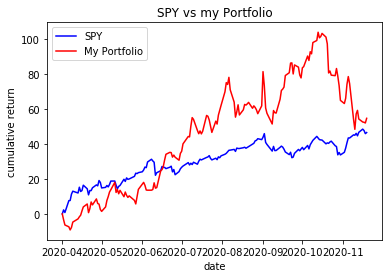

In [1]:
import sys
import matplotlib.pyplot as plt
import PyQt5.QtWidgets as qtw
from PyQt5.QtGui import QStandardItemModel, QStandardItem, QFont
from PyQt5.QtGui import QIcon
from PyQt5 import QtGui
from PyQt5.QtCore import QAbstractTableModel
from bs4 import BeautifulSoup as bs
import requests
import re
import json
import pandas as pd
import numpy as np
import yahoo_fin.stock_info as si
import datetime
from lxml import html

# Import the datasets
price_data = pd.read_csv("../stock_price_data_from_2016.csv", index_col=0)
price_data["date"] = price_data.index
fundamental_data = pd.read_csv("../fundamentals.csv", index_col=0)
test_df = price_data[price_data.ticker == "MSFT"]

# get a list of all countries
with open("../countries.json", "r") as f:
    countries = json.load(f)

# List, Dictionary for the dates
years = ["2016", "2017", "2018", "2019", "2020"]
months_days_dict = {
    "January": list(range(1, 32)),
    "February": list(range(1, 29)),
    "March": list(range(1, 32)),
    "April": list(range(1, 31)),
    "May": list(range(1, 32)),
    "June": list(range(1, 31)),
    "July": list(range(1, 32)),
    "August": list(range(1, 32)),
    "September": list(range(1, 31)),
    "October": list(range(1, 32)),
    "November": list(range(1, 31)),
    "December": list(range(1, 32))
}


class MainWindow(qtw.QWidget):
    # widgets are attached here
    def __init__(self):
        super().__init__()
        self.setWindowTitle("PortfolioManager")
        self.setWindowIcon(QIcon("stock-market.png"))
        mainLayout = qtw.QGridLayout()

        self.model_1 = QStandardItemModel()
        self.model_2 = QStandardItemModel()
        self.setLayout(mainLayout)

        self.show()

        # Widgets------------------------------------------------------------------------------------------------------#

        # Labels
        self.lb_1 = qtw.QLabel("Geben Sie Start- und Enddatum an")
        self.lb_2 = qtw.QLabel("Startdatum")
        self.lb_3 = qtw.QLabel("Enddatum")
        self.lb_4 = qtw.QLabel("Auf welche Faktoren so die Analyse basieren?")

        # Comboboxes
        self.cbo_1 = qtw.QComboBox()
        self.cbo_1.addItems(years)

        self.cbo_2 = qtw.QComboBox()
        self.cbo_2.setModel(self.model_1)

        self.cbo_3 = qtw.QComboBox()
        self.cbo_3.setModel(self.model_1)

        self.cbo_4 = qtw.QComboBox()
        self.cbo_4.addItems(years)

        self.cbo_5 = qtw.QComboBox()
        self.cbo_5.setModel(self.model_2)

        self.cbo_6 = qtw.QComboBox()
        self.cbo_6.setModel(self.model_2)

        # CheckBoxes
        self.chx_1 = qtw.QCheckBox("Momentum")
        self.chx_2 = qtw.QCheckBox("Value")
        self.chx_3 = qtw.QCheckBox("Profit")
        self.chx_1.setChecked(True)
        self.chx_2.setChecked(True)
        self.chx_3.setChecked(True)

        # Button
        self.btn_1 = qtw.QPushButton("Start Analysis")
        self.btn_1.clicked.connect(self.start_analysis)
        self.btn_2 = qtw.QPushButton("Performance until today")
        self.btn_2.clicked.connect(self.past_performance)

        # add combobox data
        # add Data
        for k, v in months_days_dict.items():
            month = QStandardItem(k)
            self.model_1.appendRow(month)
            for value in v:
                day = QStandardItem(str(value))
                month.appendRow(day)

        for k, v in months_days_dict.items():
            month = QStandardItem(k)
            self.model_2.appendRow(month)
            for value in v:
                day = QStandardItem(str(value))
                month.appendRow(day)

        self.cbo_2.currentIndexChanged.connect(self.update_combo_1)
        self.update_combo_1(0)

        self.cbo_5.currentIndexChanged.connect(self.update_combo_2)
        self.update_combo_2(0)

        # progress bar
        self.progress_bar = qtw.QProgressBar(self)
        self.progress_bar.setValue(0)

        # Layouts------------------------------------------------------------------------------------------------------#

        # Labels
        mainLayout.layout().addWidget(self.lb_1, 0, 0, 1, 6)
        mainLayout.layout().addWidget(self.lb_2, 1, 0, 1, 2)
        mainLayout.layout().addWidget(self.lb_3, 1, 3, 1, 2)
        mainLayout.layout().addWidget(self.lb_4, 3, 0, 1, 4)

        # Comboboxes
        mainLayout.layout().addWidget(self.cbo_1, 2, 0)
        mainLayout.layout().addWidget(self.cbo_2, 2, 1)
        mainLayout.layout().addWidget(self.cbo_3, 2, 2)
        mainLayout.layout().addWidget(self.cbo_4, 2, 3)
        mainLayout.layout().addWidget(self.cbo_5, 2, 4)
        mainLayout.layout().addWidget(self.cbo_6, 2, 5)

        # Checkboxes
        mainLayout.layout().addWidget(self.chx_1, 4, 0)
        mainLayout.layout().addWidget(self.chx_2, 4, 1)
        mainLayout.layout().addWidget(self.chx_3, 4, 2)

        # Buttons
        mainLayout.layout().addWidget(self.btn_1, 5, 0, 1, 6)

        # Progress Bar
        mainLayout.layout().addWidget(self.progress_bar, 6, 0, 1, 6)

    # Functions--------------------------------------------------------------------------------------------------------#

    def stop_program(self):
        sys.exit()

    def increase_step(self):
        self.progress_bar.setValue(self.progress_bar.value() + 1)

    def get_maximum_progress(self):
        checked_list = [self.chx_1.isChecked(), self.chx_2.isChecked(), self.chx_3.isChecked()]
        if checked_list == [True, True, True]:
            self.progress_bar.setMaximum(91)
        elif checked_list == [True, False, True] or checked_list == [True, True, False]:
            self.progress_bar.setMaximum(79)
        elif checked_list == [False, True, True]:
            self.progress_bar.setMaximum(59)
        elif checked_list == [True, False, False]:
            self.progress_bar.setMaximum(32)
        elif checked_list == [False, True, False] or checked_list == [False, False, True]:
            self.progress_bar.setMaximum(47)
        elif checked_list == [False, False, True]:
            message = qtw.QMessageBox.about(self, "Error", "Please choose factors")
            # TODO reset the program





    def update_combo_1(self, index):
        indx = self.model_1.index(index, 0, self.cbo_1.rootModelIndex())
        self.cbo_3.setRootModelIndex(indx)
        self.cbo_3.setCurrentIndex(0)

    def update_combo_2(self, index):
        indx = self.model_2.index(index, 0, self.cbo_5.rootModelIndex())
        self.cbo_6.setRootModelIndex(indx)
        self.cbo_6.setCurrentIndex(0)

    def get_funds_date(self, year, month, day, ticker):
        date = datetime.date(year, month, day)
        start_date = date.strftime("%Y-%m-%d")

        # first check if there is a date before the starting date of the analysis
        ticker_funds = fundamental_data[fundamental_data.ticker == ticker]
        ticker_funds = ticker_funds.sort_values(by="date", ascending=False)
        for date in ticker_funds.date:
            if date < start_date:
                day = int(date[-2:])
                month = int(date[-5:-3])
                year = int(date[:4])
                date = datetime.date(year, month, day)
                date = date.strftime("%Y-%m-%d")
                return date
        return np.nan

    def get_correct_date(self, day, month, year, test_df):
        date = datetime.date(year, month, day)
        date = date.strftime("%Y-%m-%d")
        while len(test_df[test_df.date == date]) == 0:
            if month == 12 and day == 31:
                year += 1
                day = 1
                month = 1
                date = datetime.date(year, month, day)
                date = date.strftime("%Y-%m-%d")

            else:
                try:
                    day += 1
                    date = datetime.date(year, month, day)
                    date = date.strftime("%Y-%m-%d")

                except:
                    month += 1
                    day = 1
                    date = datetime.date(year, month, day)
                    date = date.strftime("%Y-%m-%d")
        return date

    def get_latest_fundamentals(self):
        print("get_funds")
        funds_dates = []
        funds_ticker = []
        funds_at = []
        funds_op = []
        funds_so = []
        prices = []
        # for progress bar. This should be 15 percent.
        count = 0
        stepper = len(fundamental_data.ticker.unique()) // 35

        for ticker in fundamental_data.ticker.unique():

            rel_date = self.get_funds_date(int(self.cbo_1.currentText()),
                                           list(months_days_dict.keys()).index(self.cbo_2.currentText()) + 1,
                                           int(self.cbo_3.currentText()), ticker)
            try:
                funds_at.append(
                    fundamental_data[(fundamental_data.date == rel_date) & (fundamental_data.ticker == ticker)][
                        "at"].item())
            except:
                funds_at.append(np.nan)
            try:
                funds_op.append(
                    fundamental_data[(fundamental_data.date == rel_date) & (fundamental_data.ticker == ticker)][
                        "op"].item())
            except:
                funds_op.append(np.nan)
            try:
                funds_so.append(
                    fundamental_data[(fundamental_data.date == rel_date) & (fundamental_data.ticker == ticker)][
                        "so"].item())
            except:
                funds_so.append(np.nan)
            try:
                prices.append(start_price[start_price.ticker == ticker]["adjclose"].item())
            except:
                prices.append(np.nan)

            funds_dates.append(rel_date)
            funds_ticker.append(ticker)
            count += 1
            if count % stepper == 0:
                self.increase_step()

        global fund_df
        fund_df = pd.DataFrame({
            "ticker": funds_ticker,
            "date": funds_dates,
            "at": funds_at,
            "op": funds_op,
            "so": funds_so,
            "adjclose": prices
        })

        # market value
        fund_df["mar_cap"] = fund_df.so * fund_df.adjclose
        # book-to-market
        fund_df["beme"] = fund_df["at"] / fund_df["mar_cap"]
        # Profitability
        fund_df["prof"] = fund_df["op"] / fund_df["at"]

        return fund_df

    def compute_momentum(self):
        print("comp_mom")
        # two dataframes
        end_price = price_data[price_data.date == end_date]
        momentum_list = []
        mom_ticker_list = []
        # vars for progress bar, here should be 5% progress made
        count = 0
        stepper = len(start_price) // 5
        print(stepper)
        for ticker in start_price.ticker:
            try:
                date_price = start_price[start_price.ticker == ticker][:1]["adjclose"].item()
                today_price = end_price[end_price.ticker == ticker][:1]["adjclose"].item()
                momentum = today_price - date_price
                momentum_list.append(momentum)
                mom_ticker_list.append(ticker)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

            except:
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        global m_df
        m_df = pd.DataFrame({
            "ticker": mom_ticker_list,
            "momentum": momentum_list
        })

        m_df = m_df.sort_values(by="momentum", ascending=False)
        m_df.reset_index(drop=True, inplace=True)

        return m_df

    def momentum_scraping(self):
        print("mom scrape")
        name_list = []

        # for progress bar. This should be 18%
        count = 0
        stepper = len(momentum_stocks) // 9
        print(stepper)
        for ticker in momentum_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
                response = requests.get(url.format(ticker, ticker))
                soup = bs(response.text, "html.parser")
                pattern = re.compile(r"\s--\sData\s--\s")
                script_data = soup.find("script", text=pattern).contents[0]
                start = script_data.find("context") - 2
                json_data = json.loads(script_data[start:-12])
                short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
                name_list.append(short_name)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                name_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        # reset count
        count = 0
        country_list = []

        for ticker in momentum_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"

                r = requests.get(url.format(ticker, ticker))
                soup = bs(r.content, features="lxml")
                info = soup.find_all("p", attrs={"class", "D(ib) W(47.727%) Pend(40px)"})
                info[0].text
                for c in countries:
                    if c in info[0].text:
                        country_list.append(c)
                        break
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                country_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        # reset count
        count = 0
        industry_list = []

        for ticker in momentum_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"
                response = requests.get(url.format(ticker, ticker))
                soup = bs(response.text, features="lxml")

                industry = soup.find_all("span", {"class": "Fw(600)"})[0].text
                industry_list.append(industry)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                industry_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        global momentum_df
        momentum_df = pd.DataFrame({
            "ticker": momentum_stocks,
            "names": name_list,
            "industry": industry_list,
            "country": country_list

        })
        momentum_df = momentum_df.dropna()
        return momentum_df

    def value_scraping(self):
        print("val_scrape")
        name_list = []
        # for progress bar. This should be 9%
        count = 0
        stepper = len(value_stocks) // 4

        for ticker in value_stocks:
            try:
                url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
                response = requests.get(url_shares_outstanding.format(ticker, ticker))
                soup = bs(response.text, "html.parser")
                pattern = re.compile(r"\s--\sData\s--\s")
                script_data = soup.find("script", text=pattern).contents[0]
                start = script_data.find("context") - 2
                json_data = json.loads(script_data[start:-12])
                short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
                name_list.append(short_name)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                name_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
        # reset count
        count = 0
        country_list = []

        for ticker in value_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"

                r = requests.get(url.format(ticker, ticker))
                soup = bs(r.content, features="lxml")
                info = soup.find_all("p", attrs={"class", "D(ib) W(47.727%) Pend(40px)"})
                for c in countries:
                    if c in info[0].text:
                        country_list.append(c)
                        break
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                country_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        # reset count
        count = 0
        industry_list = []

        for ticker in value_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"
                response = requests.get(url.format(ticker, ticker))
                soup = bs(response.text, features="lxml")

                industry = soup.find_all("span", {"class": "Fw(600)"})[0].text
                industry_list.append(industry)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                industry_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        global value_df
        value_df = pd.DataFrame({
            "ticker": value_stocks,
            "names": name_list,
            "industry": industry_list,
            "country": country_list

        })
        value_df = value_df.dropna()
        return value_df

    def profit_scraping(self):
        print("pro_scrape")

        name_list = []
        # for progress bar. This should be 9%
        count = 0
        stepper = len(profit_stocks) // 4

        for ticker in profit_stocks:
            try:
                url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
                response = requests.get(url_shares_outstanding.format(ticker, ticker))
                soup = bs(response.text, "html.parser")
                pattern = re.compile(r"\s--\sData\s--\s")
                script_data = soup.find("script", text=pattern).contents[0]
                start = script_data.find("context") - 2
                json_data = json.loads(script_data[start:-12])
                short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
                name_list.append(short_name)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                name_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        # reset count
        count = 0
        country_list = []

        for ticker in profit_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"

                r = requests.get(url.format(ticker, ticker))
                soup = bs(r.content, features="lxml")
                info = soup.find_all("p", attrs={"class", "D(ib) W(47.727%) Pend(40px)"})
                info[0].text
                for c in countries:
                    if c in info[0].text:
                        country_list.append(c)
                        break
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                country_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        # reset count
        count = 0
        industry_list = []

        for ticker in profit_stocks:
            try:
                url = "https://finance.yahoo.com/quote/{}/profile?p={}"
                response = requests.get(url.format(ticker, ticker))
                soup = bs(response.text, "lxml")

                industry = soup.find_all("span", {"class": "Fw(600)"})[0].text
                industry_list.append(industry)
                count += 1
                if count % stepper == 0:
                    self.increase_step()
            except:
                industry_list.append(np.nan)
                count += 1
                if count % stepper == 0:
                    self.increase_step()

        global profit_df
        profit_df = pd.DataFrame({
            "ticker": profit_stocks,
            "names": name_list,
            "industry": industry_list,
            "country": country_list

        })
        profit_df = profit_df.dropna()
        return profit_df

    def diversify_portfolio(self):
        print("duversify")
        global portfolio_df
        portfolio_df = pd.DataFrame(columns=["ticker", "names", "industry", "country"])
        index = 0
        mom = 0
        val = 0
        pro = 0
        origin_list = []  # list for the origins of the stocks
        c_list = []
        i_list = []

        while (len(portfolio_df) < 15) & (index < index_num):

            try:
                if mom <= 5 and momentum_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(
                        momentum_df.loc[index]["country"]) < 4 and i_list.count(momentum_df.loc[index]["industry"]) < 2:

                    portfolio_df = portfolio_df.append(momentum_df.loc[index])
                    c_list.append(momentum_df.loc[index]["country"])
                    i_list.append(momentum_df.loc[index]["industry"])
                    mom += 1
                    origin_list.append("mom")
                    index += 1


                elif val <= 3 and value_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(
                        value_df.loc[index]["country"]) < 4 and i_list.count(value_df.loc[index]["industry"]) < 2:

                    portfolio_df = portfolio_df.append(value_df.loc[index])

                    c_list.append(value_df.loc[index]["country"])
                    i_list.append(value_df.loc[index]["industry"])
                    val += 1
                    origin_list.append("val")


                elif pro <= 3 and profit_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(
                        profit_df.loc[index]["country"]) < 4 and i_list.count(profit_df.loc[index]["industry"]) < 2:

                    portfolio_df = portfolio_df.append(profit_df.loc[index])

                    c_list.append(profit_df.loc[index]["country"])
                    i_list.append(profit_df.loc[index]["industry"])
                    pro += 1
                    origin_list.append("pro")
                else:
                    index += 1


            except:
                index += 1

        portfolio_df["origin"] = origin_list
        portfolio_df.reset_index(drop=True, inplace=True)

        return portfolio_df

    def past_performance(self):
        today = price_data.date[-1] # latest date in our dataset

        port_data = pd.DataFrame()

        for ticker in portfolio_df.ticker:
            try:
                stock_df = si.get_data(ticker, start_date=end_date, end_date=today)[["adjclose", "ticker"]]
                port_data = port_data.append(stock_df)
            except:
                pass

        spy = si.get_data("spy", start_date=end_date, end_date=today)
        spy = spy[["adjclose", "ticker"]]
        nan_ticker = port_data[port_data.adjclose.isna()]["ticker"].unique()

        port_data = port_data[~port_data.ticker.isin(nan_ticker)]
        port_data.reset_index(drop=True, inplace=True)

        unique_tickers = port_data.ticker.unique()
        data_df_list = []
        for ticker in unique_tickers:
            return_list = [np.nan]
            ticker_df = port_data[port_data.ticker == ticker]
            n = 1
            ticker_df.reset_index(drop=True, inplace=True)
            while n <= len(ticker_df) - 1:
                day_ret = ((ticker_df.loc[n]["adjclose"] - ticker_df.loc[n - 1]["adjclose"]) / ticker_df.loc[n - 1][
                    "adjclose"]) * 100
                return_list.append(day_ret)
                n += 1
            ticker_df["returns"] = return_list
            data_df_list.append(ticker_df)

        live_prices = []

        for tick in portfolio_df.ticker:
            t = si.get_live_price(tick)
            print(t)
            live_prices.append(t)

        portfolio_df["live_price"] = live_prices

        lenghts = [len(i) for i in data_df_list]
        max_len = max(lenghts)
        print("das maximum:", max_len)

        for index, d in enumerate(data_df_list):
            print(len(d))

        relevant_df_list = []
        for df in data_df_list:
            if len(df) == max_len:
                relevant_df_list.append(df)

        kum_ret = []
        n = 0
        while n < len(spy):
            ret = ((spy.adjclose[n] - spy.adjclose[0]) / spy.adjclose[0]) * 100
            kum_ret.append(ret)
            n += 1
        spy["kum_ret"] = kum_ret

        for df in data_df_list:
            kum_ret = []
            n = 0
            while n < len(df):
                ret = ((df.adjclose[n] - df.adjclose[0]) / df.adjclose[0]) * 100
                kum_ret.append(ret)
                n += 1
            df["kum_ret"] = kum_ret

        investment = 300
        # TODO add entry with investment

        fraction_list = []

        for price in live_prices:
            fraction = investment / (len(live_prices)) / price
            fraction_list.append(fraction)

        portfolio_df["fraction"] = fraction_list

        n = 0
        kum_port_rets = []
        while n < len(spy):
            rets = [relevant_df_list[m].loc[n]["kum_ret"] for m in range(len(relevant_df_list))]
            kum_port_ret = sum(rets) / len(relevant_df_list)
            kum_port_rets.append(kum_port_ret)
            n += 1
        spy["kum_port_rets"] = kum_port_rets

        plt.plot(spy.index, spy.kum_ret, "blue", label="SPY")
        plt.plot(spy.index, spy.kum_port_rets, "red", label="My Portfolio")
        plt.legend()
        plt.xlabel("date")
        plt.ylabel("cumulative return")
        plt.title("SPY vs my Portfolio")



    def start_analysis(self):
        self.get_maximum_progress()
        print("start")
        # set the progress maximums
        # self.btn_1.clicked.connect(stop_program)
        # get the correct dates so that we dont have empty dfs
        global start_date
        global end_date
        global start_price
        global index_num  # for portfolio index later
        start_date = self.get_correct_date(int(self.cbo_3.currentText()),
                                           list(months_days_dict.keys()).index(self.cbo_2.currentText()) + 1,
                                           int(self.cbo_1.currentText()), test_df)
        end_date = self.get_correct_date(int(self.cbo_6.currentText()),
                                         list(months_days_dict.keys()).index(self.cbo_5.currentText()) + 1,
                                         int(self.cbo_4.currentText()), test_df)
        if end_date < start_date:
            error = qtw.QMessageBox.about(self, "Error", "Das Startdatum muss von dem Enddatum liegen!")
            # TODO
            #RESET THE PROGRAM
        start_price = price_data[price_data.date == start_date]
        # compute factor companies depending on checkboxes

        if self.chx_2.isChecked() or self.chx_3.isChecked():

            self.get_latest_fundamentals()
            if self.chx_2.isChecked():
                value_stocks_df = fund_df.sort_values(by="beme", ascending=False)
                global value_stocks
                value_stocks = value_stocks_df[:15]["ticker"].to_list()
                self.value_scraping()
                print("val done")
                index_num = 15

            if self.chx_3.isChecked():
                profit_stocks_df = fund_df.sort_values(by="prof", ascending=False)
                global profit_stocks
                profit_stocks = profit_stocks_df[:15]["ticker"].to_list()
                self.profit_scraping()
                print("pro done")
                index_num = 15

        if self.chx_1.isChecked():
            # momentum df
            self.compute_momentum()
            global momentum_stocks
            momentum_stocks = m_df[:40]["ticker"].to_list()
            self.momentum_scraping()
            index_num = 30

        # diversify portfolio
        self.diversify_portfolio()
        print(portfolio_df)

        self.portfolio_table = qtw.QTableView()
        # TODO ass portfolio table here
        print("ich bin feddy")

        self.past_performance()
        #self.btn_2 = MainWindow.layout().addWidget(self.btn_2, 6, 0, 1, 6)


app = qtw.QApplication(sys.argv)
# app.setStyleSheet(stylesheet)
mw = MainWindow()
app.exec_()  # tells python to run the app


In [35]:
spy = si.get_data("spy", start_date=end_date, end_date=today)

nan_ticker = port_data[port_data.adjclose.isna()]["ticker"].unique()
port_data = port_data[~port_data.ticker.isin(nan_ticker)]

In [34]:
spy

,adjclose,ticker
2020-03-02,304.716980,SPY
2020-03-03,295.992218,SPY
2020-03-04,308.433655,SPY
2020-03-05,298.180817,SPY
2020-03-06,293.251556,SPY
...,...,...
2020-11-13,358.100006,SPY
2020-11-16,362.570007,SPY
2020-11-17,360.619995,SPY
2020-11-18,356.279999,SPY


In [174]:
today = "20.11.2020"
today = get_correct_date(today, test_df)


In [175]:
port_data = pd.DataFrame()

for ticker in portfolio_df.ticker:
    try:
        stock_df = si.get_data(ticker, start_date = end_date, end_date = today)[[ "adjclose", "ticker"]]
        port_data = port_data.append(stock_df)
    except:
        pass

spy = si.get_data("spy", start_date = end_date, end_date = today)[["adjclose", "ticker"]]

In [176]:
nan_ticker = port_data[port_data.adjclose.isna()]["ticker"].unique()

port_data = port_data[~port_data.ticker.isin(nan_ticker)]
port_data.reset_index(drop = True, inplace = True)

calculate returns 

In [177]:
unique_tickers = port_data.ticker.unique()
data_df_list = []
for ticker in unique_tickers:
    return_list = [np.nan]
    ticker_df = port_data[port_data.ticker == ticker]
    n = 1
    ticker_df.reset_index(drop = True, inplace = True)
    while n <= len(ticker_df) - 1:
        day_ret = ((ticker_df.loc[n]["adjclose"] - ticker_df.loc[n-1]["adjclose"])/ticker_df.loc[n-1]["adjclose"]) * 100
        return_list.append(day_ret)
        n += 1
    ticker_df["returns"] = return_list
    data_df_list.append(ticker_df)
    

C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [178]:
rets = []
for adj1, adj2 in zip(spy["adjclose"], spy.shift()["adjclose"]):
    ret = ((adj1 - adj2)/adj2) * 100
    rets.append(ret)

spy["day_ret"] = rets

In [179]:
kum_ret = []
n = 0
while n < len(spy):
    ret = ((spy.adjclose[n] - spy.adjclose[0])/spy.adjclose[0]) * 100
    kum_ret.append(ret)
    n += 1
spy["kum_ret"] = kum_ret

In [180]:
for df in data_df_list:
    kum_ret = []
    n = 0
    while n < len(df):
        ret = ((df.adjclose[n] - df.adjclose[0])/df.adjclose[0]) * 100
        kum_ret.append(ret)
        n += 1
    df["kum_ret"] = kum_ret

C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [181]:
for index, d in enumerate(data_df_list):
    print(len(d))

204
204
204
204
204
204
204
204
204
69
204


In [182]:
lenghts = [len(i) for i in data_df_list]
max_len = max(lenghts)

for index, d in enumerate(data_df_list):
    if len(d) < max_len:
        data_df_list.pop(index)
        
portfolio_df

,ticker,names,industry,country,origin
0,PTRS,Partners Bancorp,Financial Services,United States,mom
1,NVR,"NVR, Inc.",Consumer Cyclical,United States,mom
2,CABO,"Cable One, Inc.",Communication Services,United States,mom
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,United States,mom
4,AGMH,AGM Group Holdings Inc.,Technology,Hong Kong,val
5,ANTE,AirNet Technology Inc.,Communication Services,China,val
6,BROG,Brooge Energy Limited,Energy,United Arab Emirates,val
7,SHOP,Shopify Inc.,Technology,Canada,mom
8,WTM,White Mountains Insurance Group,Financial Services,Bermuda,mom
9,CLWT,Euro Tech Holdings Company Limi,Industrials,Hong Kong,val


## Get live prices

In [183]:
live_prices = []

for tick in portfolio_df.ticker:
    t = si.get_live_price(tick)
    print(t)
    live_prices.append(t)
    
portfolio_df["live_price"] = live_prices

3075.0
4120.22021484375
1962.06005859375
3195.340087890625
14.819999694824219
1.2699999809265137
9.326000213623047
1034.3900146484375
962.010009765625
3.240000009536743
86.0
3.200000047683716


If we invested amount x, what are the fractions of the shares we would have to buy if we wanted to equally weight the stocks?

In [184]:
investment = 300

fraction_list = []

for price in live_prices:
    fraction = investment/(len(live_prices))/price
    fraction_list.append(fraction)
    
portfolio_df["fraction"] = fraction_list

In [185]:
n = 0
kum_port_rets = []
while n < len(spy):
    rets = [data_df_list[m].loc[n]["kum_ret"] for m in range(len(data_df_list))]
    kum_port_ret = sum(rets)/len(data_df_list)
    kum_port_rets.append(kum_port_ret)
    n += 1

In [186]:
spy["kum_port_rets"] = kum_port_rets

#### Add the returns to spy dataframe so we can compare them

#### Plot the kum rets and compare them

Text(0.5, 1.0, 'SPY vs my Portfolio')

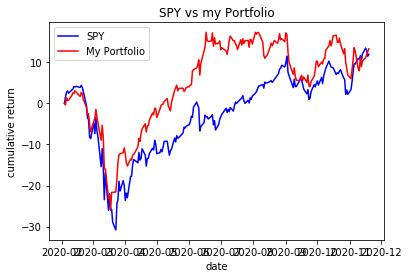

In [187]:
plt.plot(spy.index, spy.kum_ret, "blue", label = "SPY")
plt.plot(spy.index, spy.kum_port_rets, "red", label = "My Portfolio")
plt.legend()
plt.xlabel("date")
plt.ylabel("cumulative return")
plt.title("SPY vs my Portfolio")